In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.text import *

/Users/adamschiller/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = Path('data/IAM_handwriting')
TMP_PATH = PATH/'tmp'
CSV = PATH/'words.csv'

# !ls {PATH}

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Prelim

### Manual DataFrame

In [9]:
maxTextLen = 32
samples = []
chars = set()

f=open(f'{PATH}/ascii/words.txt')
for line in f:
    # ignore comment line
    if not line or line[0]=='#':
        continue

    lineSplit = line.strip().split(' ')
    assert len(lineSplit) >= 9

    fileName = lineSplit[0]

    # GT text are columns starting at 9
    gtText = ''.join(lineSplit[8:])[:maxTextLen]
    char_len = len(gtText)
    chars = chars.union(set(list(gtText)))

    # put sample into list
    samples.append([fileName, gtText, char_len])
    
data = np.stack(samples)
df = pd.DataFrame(data, columns=['filename', 'word', 'char_len'], )

In [10]:
df['char_len'] = df.char_len.astype('int32')
df = df.loc[df['char_len'] > 3]
df.head()

,filename,word,char_len
1,a01-000u-00-01,MOVE,4
3,a01-000u-00-03,stop,4
5,a01-000u-00-05,Gaitskell,9
6,a01-000u-00-06,from,4
7,a01-000u-01-00,nominating,10


### word itos

In [11]:
freq = Counter(df.word)
min_freq = 1

itos = [o for o,c in freq.most_common() if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(1, ' ')
itos.insert(2, '_unk_')
itos.insert(3, '_eos_')
len(itos)

5902

In [12]:
word_itos = itos

In [13]:
pickle.dump(word_itos, open(TMP_PATH/'synth_word_itos.pkl', 'wb'))

### Convert synth_words.csv to word_ids

In [14]:
# this is specific to synth_words.csv
# char_itos = pickle.load(open(TMP_PATH/'synth_char_itos.pkl', 'rb'))
char_itos = pickle.load(open(TMP_PATH/'char_itos.pkl', 'rb'))

#### Convert char_ids -> words -> word_ids

In [16]:
CSV = PATH/'synth_words_50000.csv'
csv = pd.read_csv(CSV)
csv.head()

,filename,char_ids
0,000.png,68 70 74 75 1 71 60 70 71 67 60 1 59 64 74 58 3
1,001.png,75 63 60 68 1 70 58 58 76 73 74 1 59 73 64 60 ...
2,002.png,59 60 67 64 62 63 75 1 73 60 56 74 70 69 56 57...
3,003.png,75 63 60 80 1 56 61 75 60 73 1 73 60 56 59 80 3
4,004.png,58 63 70 74 60 69 1 56 67 56 73 68 60 59 1 56 ...


In [24]:
res = [''.join([char_itos[int(c)] for c in line[:-2].split(' ')]) for line in csv.char_ids]

In [25]:
csv['words'] = res
csv.head()

,filename,char_ids,words
0,000.png,68 70 74 75 1 71 60 70 71 67 60 1 59 64 74 58 3,most people disc
1,001.png,75 63 60 68 1 70 58 58 76 73 74 1 59 73 64 60 ...,them occurs dried
2,002.png,59 60 67 64 62 63 75 1 73 60 56 74 70 69 56 57...,delight reasonably could
3,003.png,75 63 60 80 1 56 61 75 60 73 1 73 60 56 59 80 3,they after ready
4,004.png,58 63 70 74 60 69 1 56 67 56 73 68 60 59 1 56 ...,chosen alarmed authority


In [26]:
joined_labels = list(csv.words)

word_stoi = collections.defaultdict(lambda: 2, {v:k for k,v in enumerate(word_itos)})
ids = np.array([np.array([word_stoi[word] for word in line.split(' ')]+[3]) for line in joined_labels])

In [27]:
# convert to strings (as labels)
str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)

In [28]:
csv['word_ids'] = str_ids
csv.head()

,filename,char_ids,words,word_ids
0,000.png,68 70 74 75 1 71 60 70 71 67 60 1 59 64 74 58 3,most people disc,49 38 2597 3
1,001.png,75 63 60 68 1 70 58 58 76 73 74 1 59 73 64 60 ...,them occurs dried,22 5524 1904 3
2,002.png,59 60 67 64 62 63 75 1 73 60 56 74 70 69 56 57...,delight reasonably could,4731 1572 27 3
3,003.png,75 63 60 80 1 56 61 75 60 73 1 73 60 56 59 80 3,they after ready,13 66 716 3
4,004.png,58 63 70 74 60 69 1 56 67 56 73 68 60 59 1 56 ...,chosen alarmed authority,1455 4242 849 3


#### modify filenames to fit existing data structure

In [157]:
res = ['{:04d}'.format(i)+'.png' for i in range(10000)]

['9995.png', '9996.png', '9997.png', '9998.png', '9999.png']

In [159]:
csv['filename'] = res

### Convert synth_words.csv to char_itos format

In [ ]:
old_char_itos = pickle.load(open(TMP_PATH/'synth_char_itos.pkl', 'rb'))

In [87]:
res = [''.join([old_char_itos[int(c)] for c in line.split(' ')]) for line in char_csv.char_ids]

In [88]:
char_stoi = collections.defaultdict(lambda: 2, {v:k for k,v in enumerate(char_itos)})
ids = np.array([np.array([char_stoi[char] for char in list(line)]+[3]) for line in res])

In [89]:
# convert to strings (as labels)
str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)

In [90]:
char_csv['char_ids'] = str_ids
char_csv.head()

,filename,char_ids
0,000.png,71 73 70 71 60 73 1 64 69 61 56 75 76 56 75 64...
1,001.png,56 74 74 76 68 71 75 64 70 69 1 56 76 75 76 68...
2,002.png,78 63 60 73 60 1 57 60 58 70 68 60 1 71 60 73 ...
3,003.png,64 69 61 70 73 68 56 75 64 70 69 1 74 70 68 60...
4,004.png,62 73 60 56 75 60 74 75 1 75 60 67 67 1 74 75 ...


#### modify filenames to fit existing data structure

In [91]:
res = ['{:04d}'.format(i)+'.png' for i in range(10000)]

In [92]:
char_csv['filename'] = res
char_csv.head()

,filename,char_ids
0,0000.png,71 73 70 71 60 73 1 64 69 61 56 75 76 56 75 64...
1,0001.png,56 74 74 76 68 71 75 64 70 69 1 56 76 75 76 68...
2,0002.png,78 63 60 73 60 1 57 60 58 70 68 60 1 71 60 73 ...
3,0003.png,64 69 61 70 73 68 56 75 64 70 69 1 74 70 68 60...
4,0004.png,62 73 60 56 75 60 74 75 1 75 60 67 67 1 74 75 ...


# Helper Functions

In [5]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = np.trim_zeros(ints)   # remove padding (0)
    return ''.join([itos[i] for i in ints])

In [6]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    if title: ax.set_title(title)
    return ax

# Data

### Char

In [7]:
itos = pickle.load(open(TMP_PATH/'char_itos.pkl', 'rb'))

In [8]:
fname = 'synth_words_50000.csv' if device.type == 'cuda' else 'synth_words.csv'
CSV = PATH/fname
# char_csv.to_csv(CSV, columns=['filename', 'char_ids'], index=False)

csv = pd.read_csv(CSV)
len(csv)

10000

### Word

In [10]:
w_itos = pickle.load(open(TMP_PATH/'synth_word_itos.pkl', 'rb'))

In [11]:
W_CSV = PATH/'synth_word_ids.csv'
# csv.to_csv(CSV, columns=['filename', 'word_ids'], index=False)

w_csv = pd.read_csv(W_CSV)
len(w_csv)

10000

In [17]:
# only word testing
itos = w_itos
CSV = W_CSV
csv = w_csv

### Get val_idxs

In [9]:
val_idxs = np.array(csv.sample(frac=0.15).index)
len(val_idxs)

1500

### ModelData object

In [10]:
f = resnet34
sz = 64
bs = 120

In [11]:
aug_tfms = [RandomRotate(3, mode=1), RandomLighting(0.05, 0.05)]

tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
data = ImageClassifierData.from_csv(PATH, 'synth_words', CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, continuous=True)

In [12]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

#### Verify dataset transforms

In [87]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
x = denorm(x)

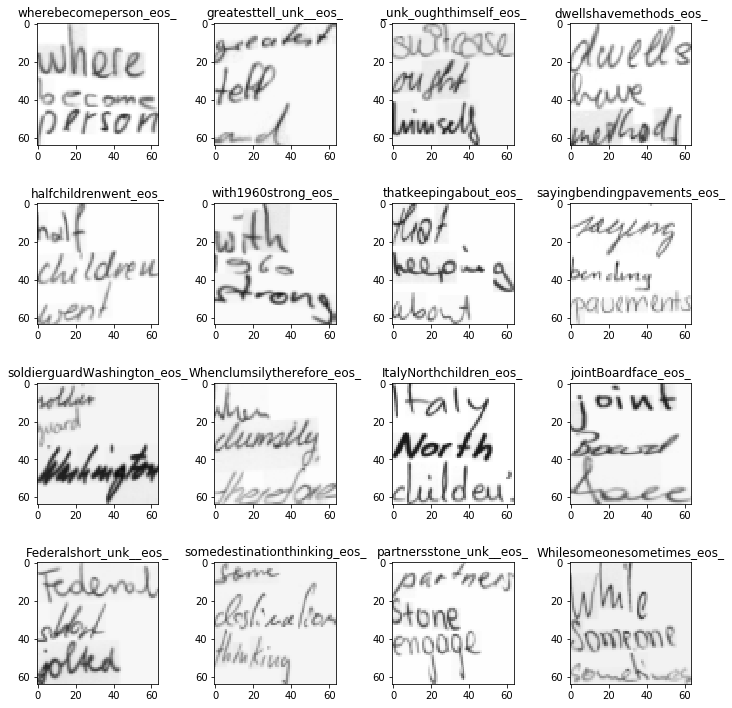

In [19]:
fig, axes = plt.subplots(4,4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i])
    ax=show_img(x[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)

### Combine word/char datasets

In [19]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [15]:
w_data = ImageClassifierData.from_csv(PATH, 'synth_words', W_CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, continuous=True)

In [21]:
trn_ds = ConcatLblDataset(data.trn_ds, w_data.trn_y)
val_ds = ConcatLblDataset(data.val_ds, w_data.val_y)
data.trn_dl.dataset = trn_ds
data.val_dl.dataset = val_ds

In [22]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

#### Verify multi-dataset

In [23]:
denorm = data.trn_ds.ds.denorm   # need the extra .ds when using ConcatLblDataset
_,(y0,y1) = next(iter(data.trn_dl))

In [24]:
chars = [itos[int(w)] for w in y0[3]]
chars

['cannot', 'were', 'only', '_eos_']

In [29]:
words = [w_itos[int(c)] for c in y1[3]]
words

['c',
 'a',
 'n',
 'n',
 'o',
 't',
 ' ',
 'w',
 'e',
 'r',
 'e',
 ' ',
 'o',
 'n',
 'l',
 'y',
 '_eos_',
 '_pad_',
 '_pad_',
 '_pad_',
 '_pad_',
 '_pad_',
 '_pad_',
 '_pad_',
 '_pad_',
 '_pad_',
 '_pad_',
 '_pad_',
 '_pad_',
 '_pad_',
 '_pad_',
 '_pad_']

# Loss and Metrics

In [13]:
# categorical cross entropy loss
# list of probabilities for each word in vocab; target is correct word

def seq2seq_loss(input, target):
    target = target.permute(1,0).contiguous()
    tsl = target.size(0)
    sl,bs,nc = input.size()
    
    if sl>tsl: target = F.pad(target, (0,0,0,sl-tsl))
    if tsl>sl: input = F.pad(input, (0,0,0,0,0,tsl-sl))
        
    targ = target.view(-1)
    pred = input.view(-1, nc)

    # combination of LogSoftmax and NLLLoss
    return F.cross_entropy(pred, targ.long(), reduction='sum')/bs

In [14]:
import Levenshtein as Lev

# pulled from Sean Nareen's deepspeech decoder module
# https://github.com/SeanNaren/deepspeech.pytorch/blob/master/decoder.py

def cer(t, p):
    """
    Computes the Character Error Rate, defined as the edit distance.
    Arguments:
        t (string): target space-separated sentence
        p (string): prediction space-separated sentence
    """
    t, p, = t.replace(' ', ''), p.replace(' ', '')
    return Lev.distance(t, p)/len(t)

def wer(s1, s2):
    """
    Computes the Word Error Rate, defined as the edit distance between the
    two provided sentences after tokenizing to words.
    Arguments:
        s1 (string): space-separated sentence
        s2 (string): space-separated sentence
    """

    # build mapping of words to integers
    b = set(s1.split() + s2.split())
    word2char = dict(zip(b, range(len(b))))

    # map the words to a char array (Levenshtein packages only accepts
    # strings)
    w1 = [chr(word2char[w]) for w in s1.split()]
    w2 = [chr(word2char[w]) for w in s2.split()]

    return Lev.distance(''.join(w1), ''.join(w2))

In [15]:
def error_label(pred):
    ints = to_np(pred).astype(int)
    ints = ints[np.nonzero(ints)]
    return ''.join([itos[i] for i in ints])

def char_error_rate(preds, targs):
    bs,sl = targs.size()      #=> ([bs, sl])
    # preds.size()            #=> ([sl, bs, vs])
        
    res = torch.argmax(preds, dim=2)
    error = 0
    for i in range(bs):
        p = error_label(res[:,i])
        t = error_label(targs[i])
        error += cer(t,p)
    return error/bs

In [34]:
def combo_error(preds, targs):
    word = char_error_rate(preds[0],targs[0])
    char = char_error_rate(preds[0],targs[1])
    return word, char

In [14]:
def combo_loss(input, target):
    word_loss = seq2seq_loss(input[0], target[0])
    char_loss = seq2seq_loss(input[0], target[1])
    return word_loss + char_loss

# Arch

In [116]:
class Encoder(nn.Module):
    def __init__(self, embed_size, drop=0.4):
        super().__init__()
        
        slices = {128: -4, 256: -3, 512: -2}
        s = slices[embed_size]
        
        net = f(True)
        modules = list(net.children())[:s]    #(8,8,256)  sz: 128
        self.base = nn.Sequential(*modules)
        
        #mlp
        self.drop = nn.Dropout(drop)
        self.linear1 = nn.Linear(embed_size, embed_size)
        self.linear2 = nn.Linear(embed_size, embed_size)
        
    def forward(self, inp):
        bs,nf,h,w = inp.size()
        
        features = self.base(inp)
        features = features.flatten(2, 3).permute(2, 0, 1)
        
        # initial hidden is an average of features fed through an MLP
        h = self.drop(features)
        h = self.linear2(F.relu(self.linear1(h))).mean(0)
                        
        return features, h

In [117]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Attention(nn.Module):
    def __init__(self, embed_size, drop=0.1):
        super().__init__()

        self.attn_1 = nn.Linear(embed_size, embed_size)
        self.attn_2 = nn.Linear(embed_size, embed_size)
        self.drop   = nn.Dropout(drop)
        self.attn_v = rand_p(embed_size)
        
    def forward(self, hidden, feats):
        # this is called once for each timestep
        w1e = self.attn_1(feats)                    # ([64, 30, 256])
        w2h = self.attn_2(hidden)                   # ([30, 256])
        u = torch.tanh(w1e + w2h)                   # ([64, 30, 256])
        u = self.drop(u)
        a = torch.softmax(u @ self.attn_v, 0)       # ([64, 30]) - attention mask
        context = (a.unsqueeze(2) * feats).sum(0)   # ([30, 256]) - weighted sum of features w/ attention
        
        return context, a

In [118]:
class RNNDecoder(nn.Module):
    def __init__(self, embed_size, num_layers, drop=0.3):
        super().__init__()
        
        self.num_layers = num_layers
        self.rnn = nn.GRU(embed_size, embed_size, num_layers)
        if self.num_layers > 1: self.rnn.dropout = drop

    def forward(self, hidden, context):
        _, h = self.rnn(context.unsqueeze(0), hidden.expand(self.num_layers, -1, -1).contiguous())
        
        return h[-1]

In [119]:
class DeepOutputLayer(nn.Module):
    def __init__(self, embed_size, vocab_size, drop=0.3):
        super().__init__()
        
        self.w0 = nn.Linear(embed_size, embed_size)
        self.w1 = nn.Linear(embed_size, embed_size)
        self.w2 = nn.Linear(embed_size, embed_size)
        self.w3 = nn.Linear(embed_size*3, vocab_size)
        self.drop = nn.Dropout(drop)
        
    def forward(self, prev, hidden, context):
        # this is called once for each timestep
        #(30,256)
        a = self.w0(prev)
        b = self.w1(hidden)
        c = self.w2(context)
        out = torch.cat([a,b,c], 1)
        
        return self.w3(self.drop(out))

In [43]:
class Net(nn.Module):
    def __init__(self, hidden_size, vocab_size, seq_len, n_layers=1, drop=0.2):
        super(Net, self).__init__()
        self.seq_len = seq_len
        
        self.encoder = Encoder(hidden_size)
        self.attention = Attention(hidden_size)
        self.decoder = RNNDecoder(hidden_size, n_layers)
        
        self.embed   = nn.Embedding(vocab_size, hidden_size)
        self.drop    = nn.Dropout(drop)
        self.embed.weight.data.uniform_(-0.1, 0.1)

        self.output  = DeepOutputLayer(hidden_size, vocab_size)
        
    def forward(self, x, ret_attn=False):
        bs = x.size(0)
        feats, hidden = self.encoder(x)
        
        res,attns = [],[]
        dec_inp = torch.ones(bs, device=device).long()
        
        for i in range(self.seq_len):
            prev = self.drop(self.embed(dec_inp))
            
            context, a = self.attention(hidden, feats)
            hidden = self.decoder(hidden, context)
            out = self.output(prev, hidden, context)
            
            res.append(out)
            attns.append(a)
            dec_inp = out.data.max(1)[1]
            
        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

In [44]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Net(256, len(itos), 5, 1)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss
learn.metrics = [char_error_rate]

# Word / Char Combo Arch

In [17]:
class Encoder(nn.Module):
    def __init__(self, embed_size, drop=0.4):
        super().__init__()
        
        slices = {128: 6, 256: 7, 512: 8}
        s = slices[embed_size]
        
        base  = ConvnetBuilder(f, 1, 0, True, xtra_fc=[embed_size]).model
        self.features = base[:s]
        self.hidden   = base[s:13]
        self.num_ws   = base[13:]
                        
    def forward(self, inp):
        bs,nf,h,w = inp.size()
        
        features = self.features(inp)
        hidden   = self.hidden(features)
        num_ws   = self.num_ws(hidden)
        num_ws   = int(torch.max(num_ws).item())
                                
        return num_ws, features, hidden

In [18]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Attention(nn.Module):
    def __init__(self, embed_size, drop=0.1):
        super().__init__()

        self.attn_1 = nn.Linear(embed_size, embed_size)
        self.attn_2 = nn.Linear(embed_size, embed_size)
        self.drop   = nn.Dropout(drop)
        self.attn_v = rand_p(embed_size)
        
    def forward(self, hidden, feats):
        w1e = self.attn_1(feats)                    # ([64, bs, 256])
        w2h = self.attn_2(hidden)                   # ([bs, 256])
        u = self.drop(torch.tanh(w1e + w2h))        # ([64, bs, 256])
        a = torch.softmax(u @ self.attn_v, 0)       # ([64, bs]) - attention mask
        context = (a.unsqueeze(2) * feats).sum(0)   # ([bs, 256]) - weighted sum of features w/ attention
        
        return context, a

In [19]:
class RNNDecoder(nn.Module):
    def __init__(self, embed_size, num_layers, drop=0.3):
        super().__init__()
        
        self.num_layers = num_layers
        self.rnn = nn.GRU(embed_size, embed_size, num_layers)
        if self.num_layers > 1: self.rnn.dropout = drop

    def forward(self, hidden, context):
        _, h = self.rnn(context.unsqueeze(0), hidden.expand(self.num_layers, -1, -1).contiguous())
        
        return h[-1]

In [20]:
class DeepOutputLayer(nn.Module):
    def __init__(self, embed_size, vocab_size, drop=0.3):
        super().__init__()
        
        self.w0 = nn.Linear(embed_size, embed_size)
        self.w1 = nn.Linear(embed_size, embed_size)
        self.w2 = nn.Linear(embed_size, embed_size)
        self.w3 = nn.Linear(embed_size*3, vocab_size)
        self.drop = nn.Dropout(drop)
        
    def forward(self, prev, hidden, context):
        #=> ([bs, 256])
        a = self.w0(prev)
        b = self.w1(hidden)
        c = self.w2(context)
        out = torch.cat([a,b,c], 1)
        
        return self.w3(self.drop(out))

In [28]:
class ConvBlock(nn.Module):
    def __init__(self, ni, nh, drop=0.2, k=3):
        super(ConvBlock, self).__init__()
        
        self.drop = nn.Dropout(drop)
        self.conv = nn.Conv2d(ni, nh, k, padding=1)  #maintain size
        self.bn   = nn.BatchNorm2d(nh)
        
    def forward(self, x):
        x = self.bn(self.conv(self.drop(x)))
        x = F.leaky_relu(x)
        return x
    
    
class WordDecoder(nn.Module):
    def __init__(self, hidden_size, layers, vocab_size):
        super().__init__()
        
        self.conv1   = ConvBlock(hidden_size, layers[0])
        self.conv2   = ConvBlock(layers[0], layers[1])
        self.linear  = nn.Linear(layers[1], vocab_size)

    def forward(self, feats):
        return self.linear(self.conv2(self.conv1(feats)))

In [44]:
class Net(nn.Module):
    def __init__(self, hidden_size, vocab_size, seq_len, n_layers=1, drop=0.2):
        super(Net, self).__init__()
        self.seq_len = seq_len
        
        self.encoder = Encoder(hidden_size)
        self.w_attention = Attention(hidden_size)
        self.c_attention = Attention(hidden_size)
        self.decoder = RNNDecoder(hidden_size, n_layers)
        
        self.embed   = nn.Embedding(vocab_size, hidden_size)
        self.drop    = nn.Dropout(drop)
        self.embed.weight.data.uniform_(-0.1, 0.1)

        self.output  = DeepOutputLayer(hidden_size, vocab_size)
        
    def forward(self, x, ret_attn=False):
        bs = x.size(0)
        num_words, feats, hidden = self.encoder(x)
        # hidden => ([bs, 256])
        # feats  => ([bs, 256, 4, 4])
        feats = feats.flatten(2, 3).permute(2, 0, 1)
                
        res,attns,w_attns = [],[],[]
        for i in range(3):
            w_hidden, a = self.w_attention(hidden, feats)   # using word attention context as char hidden
            w_attns.append(a)
                
            dec_inp = torch.ones(bs, device=device).long()
            for i in range(self.seq_len):
                prev = self.drop(self.embed(dec_inp))

                context, a = self.c_attention(w_hidden, feats)
                w_hidden = self.decoder(w_hidden, context)
                out = self.output(prev, w_hidden, context)

                res.append(out)
                attns.append(a)
                dec_inp = out.data.max(1)[1]
            
        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

In [42]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Net(256, len(itos), 20)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss
learn.metrics = [char_error_rate]

# Conv Seq2seq Arch

In [16]:
def Conv1d(in_channels, out_channels, kernel_size, dropout=0, **kwargs):
    """Weight-normalized Conv1d layer"""
    m = nn.Conv1d(in_channels, out_channels, kernel_size, **kwargs)
    std = math.sqrt((4 * (1.0 - dropout)) / (m.kernel_size[0] * in_channels))
    nn.init.normal_(m.weight, mean=0, std=std)
    nn.init.constant_(m.bias, 0)
    return nn.utils.weight_norm(m, dim=2)

def Linear(in_features, out_features, dropout=0):
    """Weight-normalized Linear layer (input: N x T x C)"""
    m = nn.Linear(in_features, out_features)
    nn.init.normal_(m.weight, mean=0, std=math.sqrt((1 - dropout) / in_features))
    nn.init.constant_(m.bias, 0)
    return nn.utils.weight_norm(m)

def Embedding(num_embeddings, embedding_dim, padding_idx=0):
    m = nn.Embedding(num_embeddings, embedding_dim, padding_idx=padding_idx)
    nn.init.normal_(m.weight, 0, 0.1)
    nn.init.constant_(m.weight[padding_idx], 0)
    return m

class GradMultiply(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, scale):
        ctx.scale = scale
        res = x.new(x)
        return res

    @staticmethod
    def backward(ctx, grad):
        return grad * ctx.scale, None

In [17]:
class ConvLayer(nn.Module):
    def __init__(self, embed_size, k, drop=0.2):
        super().__init__()
        
        self.drop = nn.Dropout(drop)
        
        padding = k // 2 if (k % 2 == 1) else 0   # maintain size w/ appropriate padding
        self.conv1 = Conv1d(embed_size, embed_size*2, k, dropout=drop, padding=padding)
        self.conv2 = Conv1d(embed_size, embed_size*2, k, dropout=drop, padding=padding)
        
        self.bn1   = nn.BatchNorm1d(embed_size)
        self.bn2   = nn.BatchNorm1d(embed_size)

    def forward(self, x):
        residual = x
        x = self.drop(x)
        x = F.glu( self.bn1( self.conv1(x) ), dim=1 )
        x = F.glu( self.bn2( self.conv2(x) ), dim=1 )
        x = (x + residual) * math.sqrt(0.5)

        return x

In [39]:
class ConvLayer(nn.Module):
    def __init__(self, embed_size, k, drop=0.2):
        super().__init__()
        
        self.drop = nn.Dropout(drop)
        padding = k // 2 if (k % 2 == 1) else 0   # maintain size w/ appropriate padding
        self.conv = Conv1d(embed_size, embed_size*2, k, dropout=drop, padding=padding)

    def forward(self, x):
        x = F.glu(self.conv(self.drop(x)), dim=1)
        return x

In [40]:
class InputEmbedding(nn.Module):
    def __init__(self, embed_size, drop=0.2):
        super().__init__()
        
        slices = {128: -4, 256: -3, 512: -2}
        s = slices[embed_size]
        
        net = f(True)
        modules = list(net.children())[:s]    #(8,8,256)  sz: 128
        self.base = nn.Sequential(*modules)
        
        self.drop = nn.Dropout(drop)
        
    def forward(self, x):
        x = self.drop(self.base(x).flatten(2, 3))
        return x

In [47]:
class Encoder(nn.Module):
    def __init__(self, embed_size, num_layers, num_dec_layers, drop=0.2):
        super().__init__()
        
        self.num_dec_layers = num_dec_layers
        
        self.convs = nn.ModuleList()
        for l in range(num_layers):
            self.convs.append(ConvLayer(embed_size,3,drop))
        
    def forward(self, input_embedding):
        x = input_embedding
        
        for conv in self.convs:
            residual = x
            x = conv(x)
            x = (x + residual) * math.sqrt(0.5)
            
        # scale gradients (this only affects backward, not forward)
        x = GradMultiply.apply(x, 1.0 / (2.0 * self.num_dec_layers))
        
        # add final output to input embedding for attention
        y = (x + input_embedding) * math.sqrt(0.5)
        
        return (x,y)   #=> (([bs, em_sz, 16]), ([bs, em_sz, 16]))

In [48]:
class ConvAttention(nn.Module):
    def __init__(self):
        super().__init__()
                
    def forward(self, x, target_embedding, encoder_out):
        residual = x
                
        x = (x + target_embedding) * math.sqrt(0.5)
        x = torch.bmm(x.permute(0, 2, 1), encoder_out[0])

        # softmax over last dim
        x = F.softmax(x, dim=-1)                            #=> ([bs, targ_len, src_len])
        attn_scores = x

        x = torch.bmm(x, encoder_out[1].permute(0, 2, 1))   #=> ([bs, targ_len, em_sz])

        # scale attention output by src_len (respecting potentially different lengths)
        s = encoder_out[1].size(-1)
        x = x * (s * math.sqrt(1.0 / s))
        
        x = x.permute(0, 2, 1)

        x = (x + residual) * math.sqrt(0.5)
        return x, attn_scores

In [49]:
class Decoder(nn.Module):
    def __init__(self, embed_size, num_layers, vocab_size, drop=0.2):
        super().__init__()
        
#         self.embed = Embedding(vocab_size, embed_size)

        self.convs = nn.ModuleList()
        self.attentions = nn.ModuleList()
        
        for l in range(num_layers):
            self.convs.append(ConvLayer(embed_size,3,drop))
            self.attentions.append(ConvAttention())
        
    def forward(self, target_embedding, encoder_out):
#         target_embedding = self.embed(target.long())        # convert floats => idxs   ([bs, 32, em_sz])
#         target_embedding = target_embedding.permute(0,2,1)  # match encoder out shapes ([bs, em_sz, 32])
        x = target_embedding
        
        attn_scores = None
        for conv,attention in zip(self.convs, self.attentions):
            residual = x
            x = conv(x)            
            x, attn_scores = attention(x, target_embedding, encoder_out)
            x = (x + residual) * math.sqrt(0.5)  # this must be before attn for training to progress

        return x, attn_scores

In [57]:
class Net(nn.Module):
    def __init__(self, embed_size, vocab_size, seq_len, enc_layers=3, dec_layers=3, drop=0.2):
        super(Net, self).__init__()
        self.seq_len = seq_len
        
        self.features = InputEmbedding(embed_size)
        self.linear   = Linear(sz//4, seq_len)
        
        self.encoder = Encoder(embed_size, enc_layers, dec_layers)
        self.decoder = Decoder(embed_size, dec_layers, vocab_size)

        #mlp
        self.drop = nn.Dropout(drop)
        self.linear1 = Linear(embed_size, embed_size//2)
        self.linear2 = Linear(embed_size//2, vocab_size)
        
    def forward(self, x, targets=None, ret_attn=False):
        bs = x.size(0)
        feats = self.features(x)

        x = self.encoder(feats)       #=> ([bs, em_sz, 16])
        targets = self.linear(feats)
        
#         targets = torch.ones((bs, self.seq_len), device=device) if targets is None else targets
        x, a = self.decoder(targets, x)     #=> ([120, 256, 31]), ([120, 31, 16])
        
        x = self.linear2(F.relu(self.drop(self.linear1( x.permute(0,2,1) ))))  #=> (bs, sl, vocab)

        # loss expects sl,bs,vocab
        x = x.permute(1,0,2).contiguous()
        return x,a if ret_attn else x

In [58]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Net(256, len(itos), 45)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss
learn.metrics = [char_error_rate]

### Testing

In [25]:
class Seq2SeqStepper(Stepper):
    def step(self, xs, y, epoch):
        self.m.pr_force = (10-epoch)*0.1 if epoch<10 else 0
        xtra = []
        output = self.m(*xs, y)
        if isinstance(output,tuple): output,*xtra = output
        self.opt.zero_grad()
        loss = raw_loss = self.crit(output, y)
        if self.reg_fn: loss = self.reg_fn(output, xtra, raw_loss)
        loss.backward()
        if self.clip:   # Gradient clipping
            nn.utils.clip_grad_norm_(trainable_params_(self.m), self.clip)
        self.opt.step()
        return raw_loss.item()
    
    def evaluate(self, xs, y):
        preds = self.m(*xs, y)
        if isinstance(preds,tuple): preds=preds[0]
        return preds, self.crit(preds, y)

In [61]:
lr = 1e-3
learn.fit(lr, 1, cycle_len=1)

# 56.095193  16.375653  0.237745
# 10.733852  6.407018   0.095873

# 53.234554  14.673208  0.158353   no residual w/in conv layer, residual prior to attn in decoder
# 79.411642  13.500457  0.143145   residual w/in conv layer, residual prior to attn in decoder
# 62.295315  10.11587   0.079368   residual w/in conv layer, residual after attn in decoder
# 45.677287  10.837221  0.08989    no residual w/in conv layer, residual after attn in decoder

# 115.-----  73.------  0.85----
# 74.114255  70.317195  0.831636

epoch      trn_loss   val_loss   char_error_rate           
    0      74.114255  70.317195  0.831636  



[70.31719501201923, 0.8316356056493109]

In [60]:
learn.save('conv_experiment')

# Arch modifications - annotated transformer, im2latex

In [41]:
class Encoder(nn.Module):
    def __init__(self, embed_size, drop=0.2):
        super().__init__()
        
        slices = {128: -4, 256: -3, 512: -2}
        s = slices[embed_size]
        
        net = f(True)
        modules = list(net.children())[:s]    #(8,8,256)  sz: 128
        self.base = nn.Sequential(*modules)
        
        #pos_enc
        self.pos_enc = PositionalEncoding(embed_size, drop)
        
        #mlp
        self.linear1 = nn.Linear(embed_size, embed_size)
        self.linear2 = nn.Linear(embed_size, embed_size)
        self.drop = nn.Dropout(drop)
        
    def forward(self, inp):
        bs,nf,h,w = inp.size()
        
        features = self.base(inp)
        features = features.flatten(2, 3).permute(2, 0, 1)
        features = self.pos_enc(features)
        
        # initial hidden is an average of features fed through an MLP
        h = F.leaky_relu(self.linear1(features.mean(0)))
        h = self.linear2(self.drop(h))
        
        # mean of features run through linear layer
#         h = torch.tanh(self.linear1(h.mean(0)))
                        
        return features, h

In [40]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, embed_size, dropout, max_len=500):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, embed_size)
        position = torch.arange(0.0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0.0, embed_size, 2) * -(math.log(10000.0) / embed_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:x.size(0)], requires_grad=False)    # ([sl, 1, 256])
        return self.dropout(x)

In [21]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Attention(nn.Module):
    def __init__(self, embed_size, drop=0.1):
        super().__init__()

        self.attn_1 = nn.Linear(embed_size, embed_size)
        self.attn_2 = nn.Linear(embed_size, embed_size)
        self.drop   = nn.Dropout(drop)
        self.attn_v = rand_p(embed_size)
        
    def forward(self, hidden, feats):
        w1e = self.attn_1(feats)                    # ([64, 30, 256])
        w2h = self.attn_2(hidden)                   # ([30, 256])
        u = torch.tanh(w1e + w2h)                   # ([64, 30, 256])
        u = self.drop(u)
        a = torch.softmax(u @ self.attn_v, 0)       # ([64, 30]) - attention mask
        context = (a.unsqueeze(2) * feats).sum(0)   # ([30, 256]) - weighted sum of features w/ attention
        
        return context, a

In [22]:
class RNNDecoder(nn.Module):
    def __init__(self, embed_size, num_layers, drop=0.3):
        super().__init__()
        
        self.num_layers = num_layers
        self.rnn = nn.GRU(embed_size, embed_size, num_layers)
        if self.num_layers > 1: self.rnn.dropout = drop

    def forward(self, hidden, context):
        _, h = self.rnn(context.unsqueeze(0), hidden.expand(self.num_layers, -1, -1).contiguous())
        
        return h[-1]

In [23]:
class DeepOutputLayer(nn.Module):
    def __init__(self, embed_size, vocab_size, drop=0.3):
        super().__init__()
        
        self.l1 = nn.Linear(embed_size*3, embed_size)
        self.l2 = nn.Linear(embed_size, vocab_size)
#         self.w0 = nn.Linear(embed_size, embed_size)
#         self.w1 = nn.Linear(embed_size, embed_size)
#         self.w2 = nn.Linear(embed_size, embed_size)
#         self.w3 = nn.Linear(embed_size*3, vocab_size)
        self.drop = nn.Dropout(drop)
        
    def forward(self, prev, hidden, context):
        # this is called once for each timestep
        #(30,256)
#         a = self.w0(prev)
#         b = self.w1(hidden)
#         c = self.w2(context)
#         out = torch.cat([a,b,c], 1)
#         out = self.w3(self.drop(out))
        out = self.l1(torch.cat([prev,hidden,context], -1))
        out = self.l2(self.drop(F.leaky_relu(out)))
        return out

In [24]:
class Embedding(nn.Module):
    def __init__(self, vocab, d_model, drop=0.2):
        super(Embedding, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        emb = self.lut(x) * math.sqrt(self.d_model)
        return self.drop(emb)

In [42]:
class Net(nn.Module):
    def __init__(self, hidden_size, vocab_size, seq_len, n_layers=1):
        super(Net, self).__init__()
        self.seq_len = seq_len
        
        self.encoder = Encoder(hidden_size)
        self.attn    = Attention(hidden_size)
        self.decoder = RNNDecoder(hidden_size, n_layers)
        self.embed   = Embedding(vocab_size, hidden_size)
        self.output  = DeepOutputLayer(hidden_size, vocab_size)
        
    def forward(self, x, ret_attn=False):
        bs = x.size(0)
        feats, hidden = self.encoder(x)
        
        res,attns = [],[]
        dec_inp = torch.ones(bs, device=device).long()
        
        for i in range(self.seq_len):
            prev = self.embed(dec_inp)
            
            context, a = self.attn(hidden, feats)
            hidden = self.decoder(hidden, context)
            out = self.output(prev, hidden, context)
            
            res.append(out)
            attns.append(a)
            dec_inp = out.data.max(1)[1]
            
        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

In [43]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Net(256, len(itos), 20)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss
learn.metrics = [char_error_rate]

In [159]:
lr=1e-3
# learn.fit(lr, 1, cycle_len=1)
# 55.378511  25.041582  0.447107

learn.fit(lr, 5, cycle_len=1, use_clr=(10,4))
# sample ~5000
# 21.156707  19.777774  0.523863    vanilla

# scan, attend, read modifications
# 21.623266  20.042625  0.557447    including 'location' attention (prev_attn.unsqueeze(2)*feats)
# 21.839842  20.125603  0.53964     including tanh layer in deepoutput

# im2latex modifications - https://guillaumegenthial.github.io/image-to-latex.html
# 21.77534   20.100386  0.554967    enc: add pos_enc to features (modified from annotated transformer)
# 21.374544  20.097782  0.57317     enc: "", feats.mean(0) prior to linear layer
# 22.104788  20.616136  0.544379    "", leaky_relu, Embedding (annotated transformer)

epoch      trn_loss   val_loss   char_error_rate          
    0      26.987927  22.325404  0.686034  
    1      24.624356  21.293182  0.466135                 
    2      23.801808  21.308162  0.453969                 
    3      22.630354  20.645247  0.513439                 
    4      22.104788  20.616136  0.544379                 


[20.616135597229004, 0.5443792303059426]

# Train

In [ ]:
lr = 1e-3
learn.fit(lr, 1, cycle_len=1, stepper=Seq2SeqStepper)
# chars
# 21.707373  21.732931  0.668435

# words+chars
# 42.288251  41.934733

# 122.970944 106.329719 1.0

In [26]:
learn.fit(lr, 3, cycle_len=1, use_clr=(10,4))
# chars
# 18.377459  18.082117  0.604478

# words+chars
# 30.31248   29.169749

epoch      trn_loss   val_loss   char_error_rate           
    0      106.292614 105.427622 1.0       
 79%|███████▉  | 56/71 [05:34<01:29,  5.96s/it, loss=106]

KeyboardInterrupt: 

In [99]:
# learn.save('3x1_word_64')
learn.save('3x1_word+char_64')

## Increase size

In [100]:
sz = 128
bs = 100

In [106]:
learn.set_data(data)

In [107]:
lr = 1e-3
learn.fit(lr, 1, cycle_len=1)
# chars
# 16.346225  15.799876  0.553588

# words+chars
# 27.268278  26.218681

epoch      trn_loss   val_loss                              
    0      27.268278  26.218681 


[26.218681360880534]

In [108]:
learn.fit(lr, 5, cycle_len=1, use_clr=(10,4))
# chars
# 4.515208   4.312007   0.218992

# words+chars
# 15.048695  15.405177

epoch      trn_loss   val_loss                              
    0      24.197201  22.702862 
    1      20.388673  19.423247                             
    2      18.024528  17.481055                             
    3      16.244249  16.335911                             
    4      15.048695  15.405177                             


[15.405176722208658]

In [109]:
# learn.save('3x1_word_128')
learn.save('3x1_word+char_128')

## Increase size

In [110]:
sz = 256
bs = 60

In [116]:
learn.set_data(data)

In [117]:
lr = 1e-3
learn.fit(lr, 1, cycle_len=1)
# chars
# 5.300004   4.813755   0.212666

# words+chars
#

epoch      trn_loss   val_loss                               
    0      16.895141  16.577382 


[16.577382369995117]

In [118]:
learn.fit(lr, 3, cycle_len=1, use_clr=(10,4))
# chars
# 1.976117   2.009706   0.107352

# words+chars
# 

epoch      trn_loss   val_loss                               
    0      16.074193  15.503848 
    1      14.344399  14.171622                              
    2      13.327054  13.433134                              


[13.433133728027343]

In [119]:
# learn.save('3x1_word_256')
learn.save('3x1_word+char_256')

# Results

In [34]:
learn.load('3x1_word_256')

In [32]:
x,y = next(iter(data.val_dl))
learn.model.eval()
preds,attns = learn.model(x, y, ret_attn=True)   #attns ([sl, 256, bs])
res = torch.argmax(preds, dim=-1)

seq2seq_loss(preds, y)

tensor(6.4019, grad_fn=<DivBackward0>)

In [33]:
char_error_rate(preds,y)

0.09816493947886794

### Text

In [40]:
for i in range(10):
    print(label_text(res[:,i]))

_unk_ _unk_ _unk_ _eos_
_unk_ _unk_ _unk_ _eos_
_unk_ _unk_ _unk_ _eos_
_unk_ _unk_ _unk_ _eos_
_unk_ _unk_ _unk_ _eos_
_unk_ _unk_ _unk_ _eos_
_unk_ _unk_ _unk_ _eos_
_unk_ _unk_ _unk_ _eos_
_unk_ _unk_ _unk_ _eos_
_unk_ _unk_ _unk_ _eos_


### Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


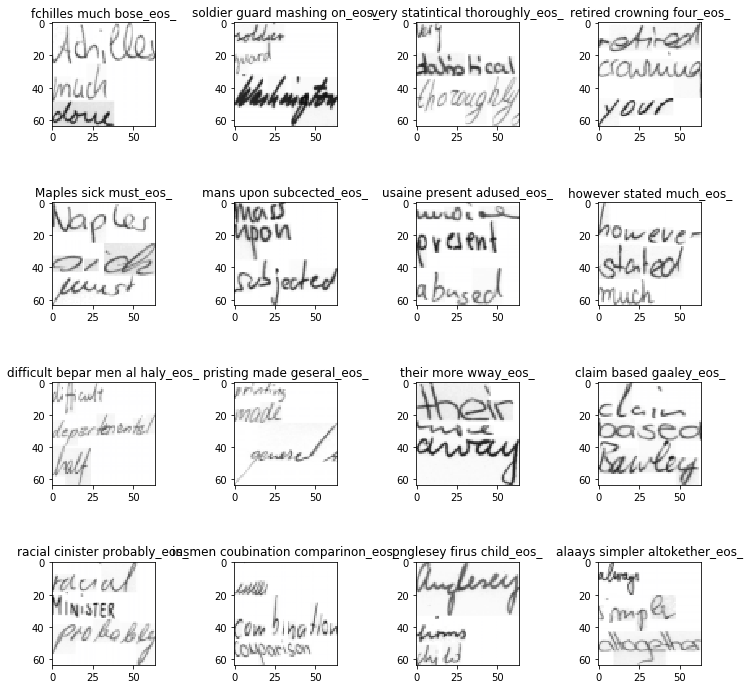

In [34]:
imgs = data.trn_ds.denorm(x)

fig, axes = plt.subplots(4,4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i])     #=>  char indices
    p = label_text(res[:,i])
    ax=show_img(imgs[i], ax=ax, title=p)#t+' '+p)
    
plt.tight_layout(pad=0.1)

### Attention

In [41]:
attns = attns.permute(1,2,0)

In [37]:
imgs = data.trn_ds.denorm(x)

In [38]:
def torch_scale_attns(attns):
    sl,_,bs = attns.shape
    num = sz // 16
    mod = attns.permute(2,0,1).view(bs,sl,num,num)
    scaled = torch.nn.functional.interpolate(mod, size=sz)
    return scaled  #([bs, sl, sz, sz])

In [39]:
from scipy.ndimage import gaussian_filter

def g_filter(att, k=16):
    return gaussian_filter(att, sigma=k)

In [45]:
idx  = 13
img  = imgs[idx]
pred = res[:,idx]
img_attns = to_np(torch_scale_attns(attns)[idx])

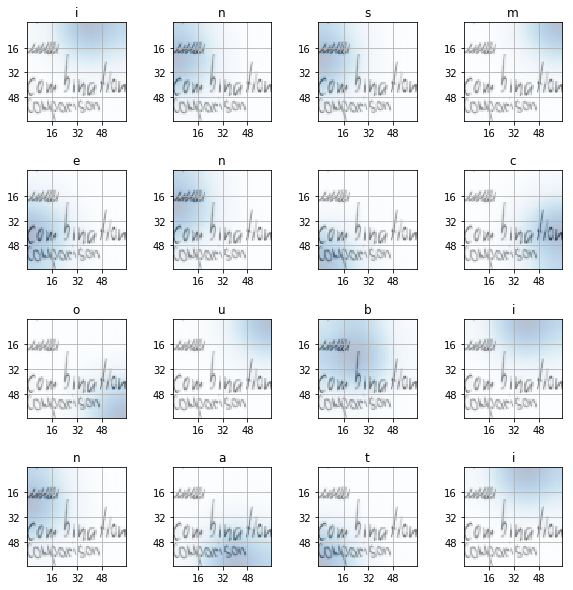

In [60]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10), gridspec_kw={'hspace': 0.5})
for i,ax in enumerate(axes.flat):
    a = g_filter(img_attns[i])
    ax.imshow(img, alpha=None)
    ax.imshow(a, cmap='Blues', interpolation='nearest', alpha=0.3)
    
    # Attention
    ticks = np.arange(16, sz, 16)
    ax.set_yticks(ticks, minor=False)
    ax.set_xticks(ticks, minor=False)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)

    ax.set_title(itos[pred[i].item()])

# Beam Search

In [48]:
preds.shape   #(sl, bs, chars)

torch.Size([20, 50, 82])

In [115]:
prob = preds[:, idx]
amts, idxs = torch.topk(prob[1], 3)
amts, idxs

(tensor([18.0591, 16.1076, 13.5562], device='cuda:0', grad_fn=<TopkBackward>),
 tensor([ 340,    2, 1327], device='cuda:0'))

In [116]:
[itos[i] for i in idxs]

['beyond', '_unk_', 'board']

In [118]:
word_stoi['legend']

2